In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
# read data from csv file
df= pd.read_csv('../data/LasVegasTripAdvisorReviews-Dataset.csv', sep= ';')
print(df.shape)
df.head(4)

(504, 20)


,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,6,February,Friday


In [3]:
df.describe()

,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Nr. rooms,Member years
count,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,48.130952,16.023810,31.751984,4.123016,2196.380952,0.767857
std,74.996426,23.957953,48.520783,1.007302,1285.476807,80.692897
min,1.000000,0.000000,0.000000,1.000000,188.000000,-1806.000000
25%,12.000000,5.000000,8.000000,4.000000,826.000000,2.000000
50%,23.500000,9.000000,16.000000,4.000000,2700.000000,4.000000
75%,54.250000,18.000000,35.000000,5.000000,3025.000000,6.000000
max,775.000000,263.000000,365.000000,5.000000,4027.000000,13.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User country       504 non-null    object
 1   Nr. reviews        504 non-null    int64 
 2   Nr. hotel reviews  504 non-null    int64 
 3   Helpful votes      504 non-null    int64 
 4   Score              504 non-null    int64 
 5   Period of stay     504 non-null    object
 6   Traveler type      504 non-null    object
 7   Pool               504 non-null    object
 8   Gym                504 non-null    object
 9   Tennis court       504 non-null    object
 10  Spa                504 non-null    object
 11  Casino             504 non-null    object
 12  Free internet      504 non-null    object
 13  Hotel name         504 non-null    object
 14  Hotel stars        504 non-null    object
 15  Nr. rooms          504 non-null    int64 
 16  User continent     504 non-null    object
 1

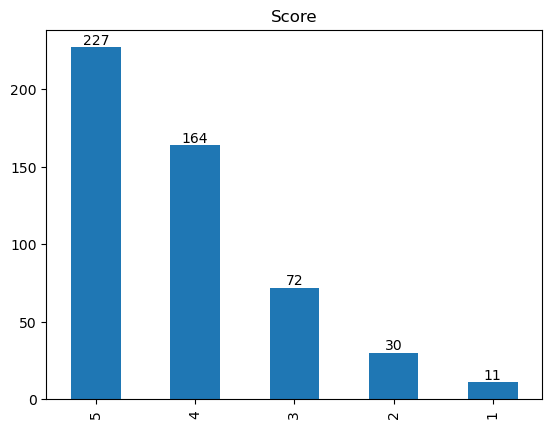

In [5]:
ax= df['Score'].value_counts().plot.bar(title='Score')
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
# có 5 mức điểm đánh giá của khách sạn

## Preprocess data

In [6]:
# data missing
miss_val = pd.DataFrame(df.isnull().sum(), columns=['No. of missing values'])
miss_val['% missing_values'] = (miss_val/len(df)).round(2)*100
miss_val
# không có missing value

,No. of missing values,% missing_values
User country,0,0.0
Nr. reviews,0,0.0
Nr. hotel reviews,0,0.0
Helpful votes,0,0.0
Score,0,0.0
Period of stay,0,0.0
Traveler type,0,0.0
Pool,0,0.0
Gym,0,0.0
Tennis court,0,0.0


##### Biến phân loại

In [7]:
cat_cols= df.drop('Score', axis= 1).select_dtypes(object).columns.tolist()
print('Có', len(cat_cols), ' biến phân loại , gồm có:', "\n", cat_cols, '\n')
for i in cat_cols:
    unique_no = df[i].nunique()
    unique_name = df[i].unique().tolist()
    print(i, 'có ', unique_no, 'có giá trị :')
    print(unique_name, "\n")
# Score là biến mục tiêu

Có 14  biến phân loại , gồm có: 
 ['User country', 'Period of stay', 'Traveler type', 'Pool', 'Gym', 'Tennis court', 'Spa', 'Casino', 'Free internet', 'Hotel name', 'Hotel stars', 'User continent', 'Review month', 'Review weekday'] 

User country có  48 có giá trị :
['USA', 'UK', 'Canada', 'India', 'Australia', 'New Zeland', 'Ireland', 'Egypt', 'Finland', 'Kenya', 'Jordan', 'Netherlands', 'Syria', 'Scotland', 'South Africa', 'Swiss', 'United Arab Emirates', 'Hungary', 'China', 'Greece', 'Mexico', 'Croatia', 'Germany', 'Malaysia', 'Thailand', 'Phillippines', 'Israel', 'India ', 'Belgium', 'Puerto Rico', 'Switzerland', 'Norway', 'France', 'Spain', 'Singapore', 'Brazil', 'Costa Rica', 'Iran', 'Saudi Arabia', 'Honduras', 'Denmark', 'Taiwan', 'Hawaii', 'Kuwait', 'Czech Republic', 'Japan', 'Korea', 'Italy'] 

Period of stay có  4 có giá trị :
['Dec-Feb', 'Mar-May', 'Jun-Aug', 'Sep-Nov'] 

Traveler type có  5 có giá trị :
['Friends', 'Business', 'Families', 'Solo', 'Couples'] 

Pool có  2 có 

In [8]:
# Chuyển hotel star về dạng float
df.replace(to_replace={'3':3,'4':4,'5':5,'3,5':3.5,'4,5':4.5},inplace=True)

In [9]:
# Trong dữ liệu có cả Swiss và Switzerland là 1 nước
df['User country'] = df['User country'].str.strip()
df.replace(to_replace={'Swiss':'Switzerland'},inplace=True)

## Phân tích các quan hệ đơn biến

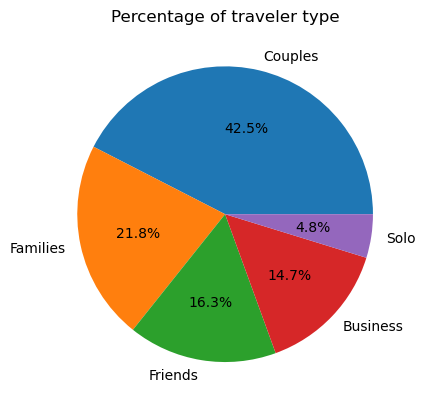

In [10]:
traveler_type = df['Traveler type'].value_counts()
plt.pie(traveler_type.values, labels = traveler_type.index, autopct='%1.1f%%')
plt.title('Percentage of traveler type');

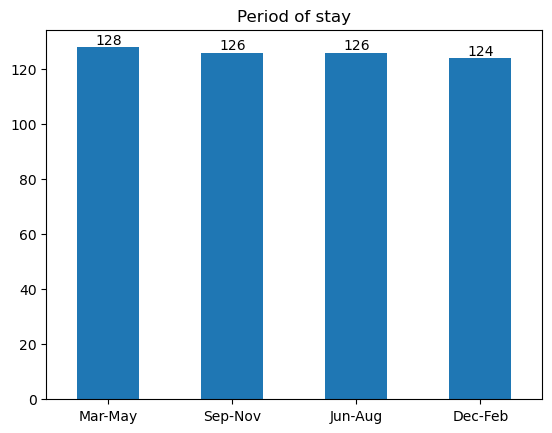

In [11]:
ax= df['Period of stay'].value_counts().plot.bar(title='Period of stay', rot= 0)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
# số lượng đánh giá theo thời gian ở

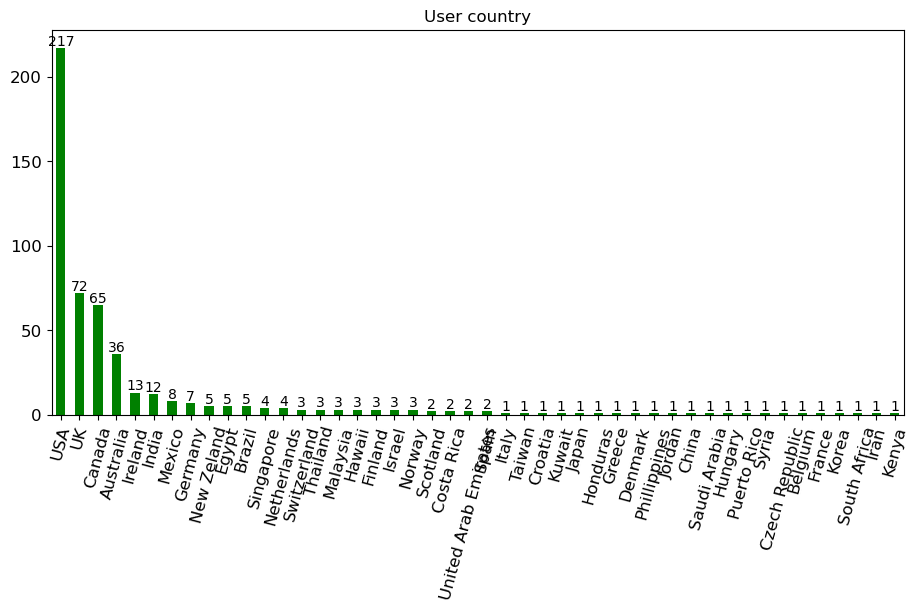

In [12]:
ax= df['User country'].value_counts().plot.bar(title='User country', figsize=(11, 5), fontsize=12, color='green', rot= 75)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
# số lượng người USA là nhiều nhất, sau đó là UK, Canada, còn lại tương đối ít

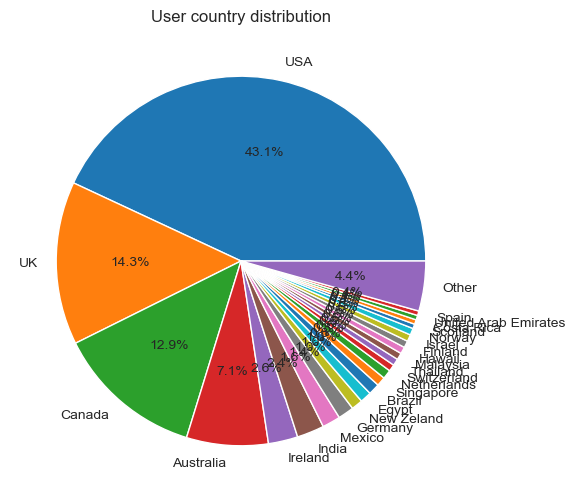

In [13]:
user_country = df['User country'].value_counts()
user_country['Other'] = (user_country==1).sum()
user_country.drop(user_country[user_country == 1].index,inplace=True)
sns.set_style('whitegrid')
plt.figure(figsize=(6,6))
plt.pie(user_country.values, labels=user_country.index, autopct='%1.1f%%')
plt.title('User country distribution');

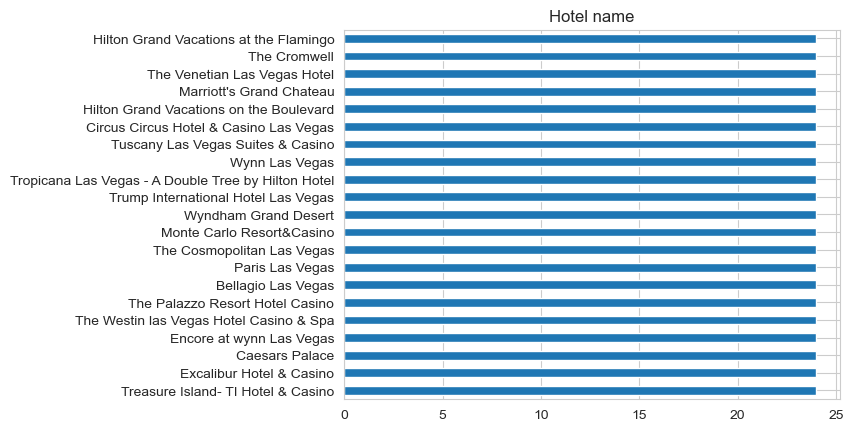

In [14]:
ax= df['Hotel name'].value_counts().plot.barh(title='Hotel name')
# số lượng đánh giá của mỗi khách sạn bằng nhau

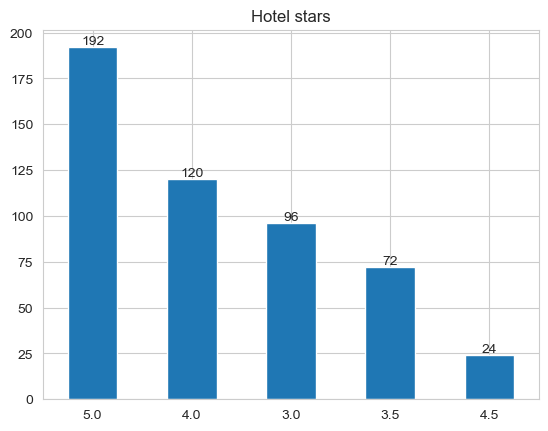

In [15]:
ax= df['Hotel stars'].value_counts().plot.bar(title='Hotel stars', rot= 0)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
# có 5 loại khách sạn

Ta thấy ở tập dữ liệu khảo sát, phần lớn là khách sạn 4-5 sao, là phân khúc khách sạn cao cấp. Từ điều này ta cũng có thể đoán được phần lớn người đánh giá được lấy mẫu thuộc phân khúc khách hàng cao cấp.

In [16]:
# tính thử chi-quare cho 2 biến phân loại
cont_table = pd.crosstab(df['Free internet'], df['Hotel stars'])
chi2, p, dof, expected = chi2_contingency(cont_table)
print("Chi-square statistic:", chi2)
print("P-value:", p)

Chi-square statistic: 80.64
P-value: 1.274696526892647e-16


##### Biến liên tục

In [17]:
# Do Score là biến mục tiêu nên không tính vào biến liên tục
num_cols = df.drop('Score', axis= 1).select_dtypes(include=np.number).columns.tolist()
print('Có :', len(num_cols), 'biến liên tục,gồm có:')
print(num_cols, "\n")

Có : 6 biến liên tục,gồm có:
['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Hotel stars', 'Nr. rooms', 'Member years'] 



In [18]:
df[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Nr. rooms', 'Member years']].describe()

,Nr. reviews,Nr. hotel reviews,Helpful votes,Nr. rooms,Member years
count,504.000000,504.000000,504.000000,504.000000,504.000000
mean,48.130952,16.023810,31.751984,2196.380952,0.767857
std,74.996426,23.957953,48.520783,1285.476807,80.692897
min,1.000000,0.000000,0.000000,188.000000,-1806.000000
25%,12.000000,5.000000,8.000000,826.000000,2.000000
50%,23.500000,9.000000,16.000000,2700.000000,4.000000
75%,54.250000,18.000000,35.000000,3025.000000,6.000000
max,775.000000,263.000000,365.000000,4027.000000,13.000000


In [19]:
# xử lý với biến Member years
df[df['Member years']<0]

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
75,USA,17,9,16,5,Dec-Feb,Solo,YES,YES,YES,YES,YES,YES,Treasure Island- TI Hotel & Casino,4.0,2884,North America,-1806,February,Monday


In [20]:
# fill biến không hợp lệ bằng median
df.loc[df[df['Member years']<0].index, 'Member years']= np.NaN
df['Member years'].fillna(df['Member years'].median(), inplace=True)

In [21]:
df[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Nr. rooms', 'Member years']].describe()

,Nr. reviews,Nr. hotel reviews,Helpful votes,Nr. rooms,Member years
count,504.000000,504.000000,504.000000,504.000000,504.000000
mean,48.130952,16.023810,31.751984,2196.380952,4.359127
std,74.996426,23.957953,48.520783,1285.476807,2.925856
min,1.000000,0.000000,0.000000,188.000000,0.000000
25%,12.000000,5.000000,8.000000,826.000000,2.000000
50%,23.500000,9.000000,16.000000,2700.000000,4.000000
75%,54.250000,18.000000,35.000000,3025.000000,6.000000
max,775.000000,263.000000,365.000000,4027.000000,13.000000


In [22]:
df[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Nr. rooms', 'Member years']].head()
# 	Nr. hotel reviews: số lượng đánh giá về khách sạn
# 	Nr. reviews: số lượng đánh giá của khách hàng
#   Nr. rooms: số lượng phòng
#   Member years: số năm người dùng là thành viên của TripAdvisor

,Nr. reviews,Nr. hotel reviews,Helpful votes,Nr. rooms,Member years
0,11,4,13,3773,9.0
1,119,21,75,3773,3.0
2,36,9,25,3773,2.0
3,14,7,14,3773,6.0
4,5,5,2,3773,7.0


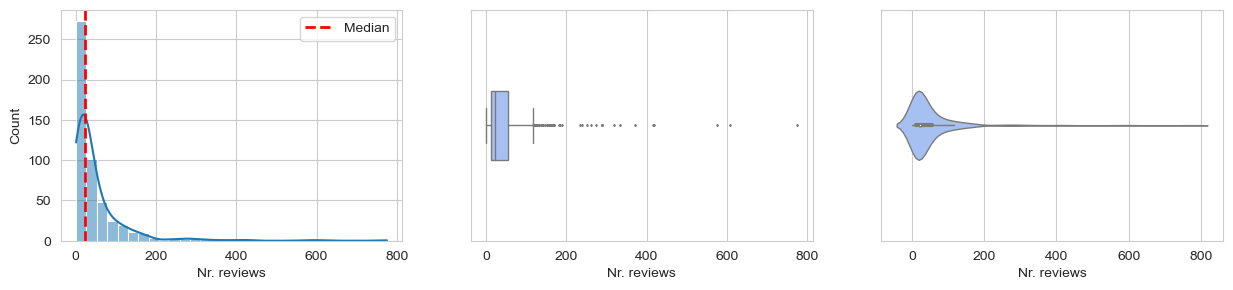

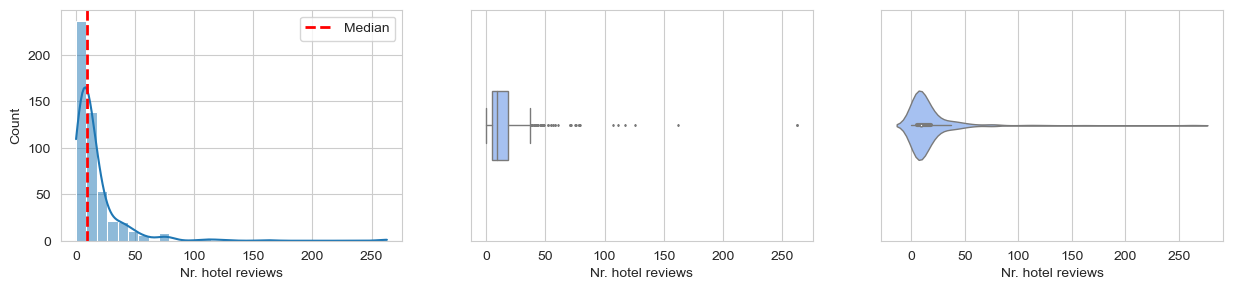

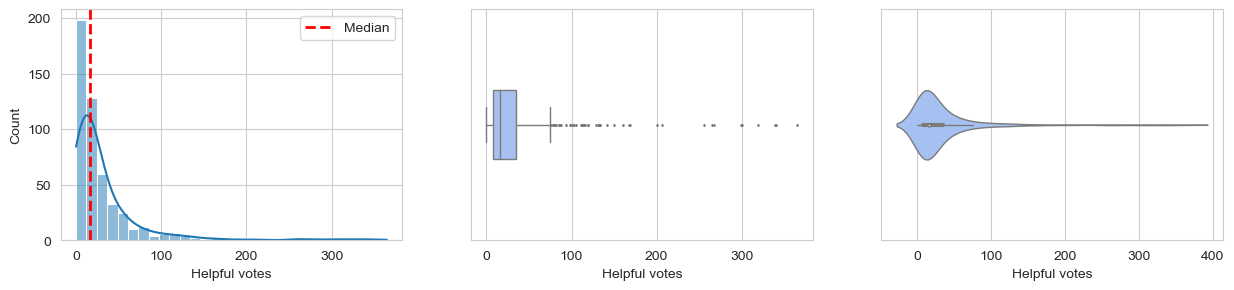

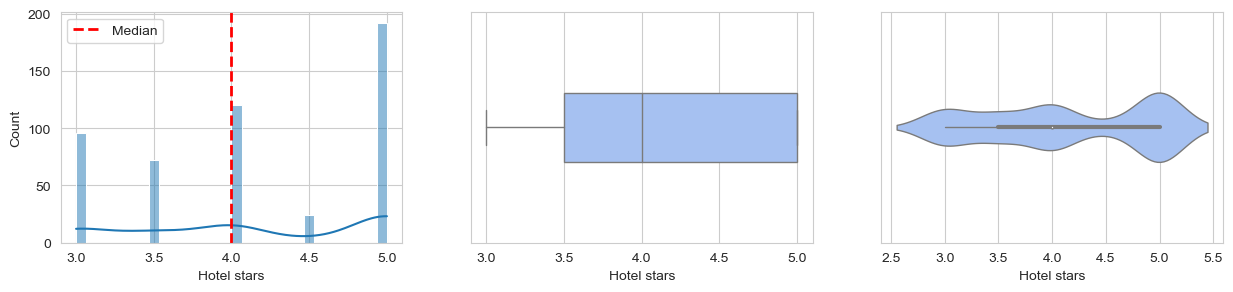

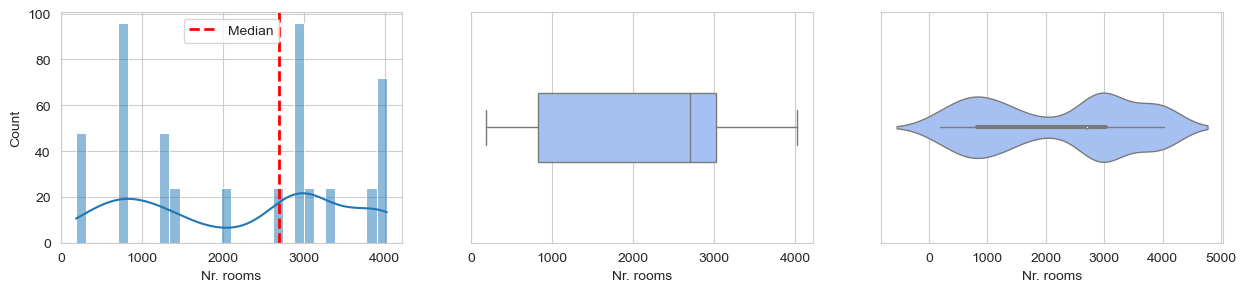

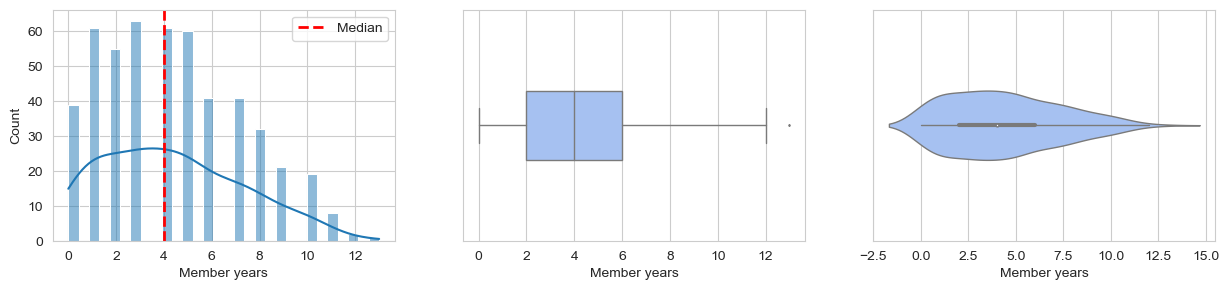

In [23]:
for i in num_cols:      
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    sns.histplot(df[i], bins= 30 , kde=True, ax=axs[0])
    sns.boxplot(df[i], ax = axs[1], color='#99befd', fliersize=1, linewidth=1, width=0.3)
    sns.violinplot(df[i], ax = axs[2], color='#99befd', fliersize=1, linewidth=1, width=0.3)
    
    axs[0].axvline(df[i].median(), color='r', linewidth=2, linestyle='--', label='Median')
    axs[0].legend()

- Các biến 'Nr. reviews', 'Nr. hotel reviews', 'Helpful votes' là positive skew (nhiều outliers).

## Phân tích quan hệ nhiều biến

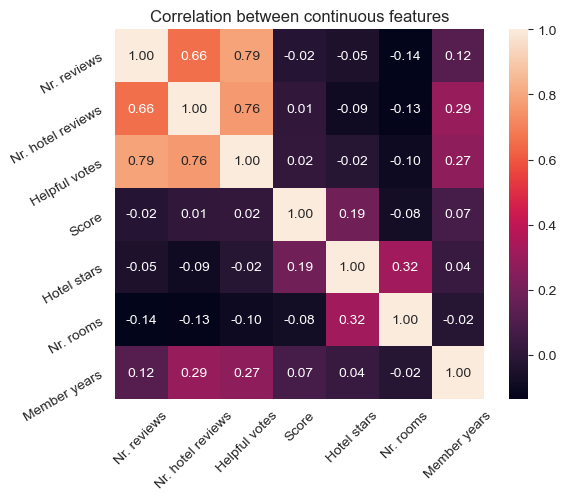

In [24]:
# ma trận tương quan
correlation = df.corr()
plt.title('Correlation between continuous features')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

- Helpful votes có tương quan với Nr. reviews cao: 0.79 chứng tỏ số lượng người reviews càng lớn thì số lượng vote hữu ích cao
- Helpful votes có tương quan với Nr. hotel reviews: 0.76 chứng tỏ số lượng reviews về khách sạn càng lớn thì số lượng vote hữu ích cao

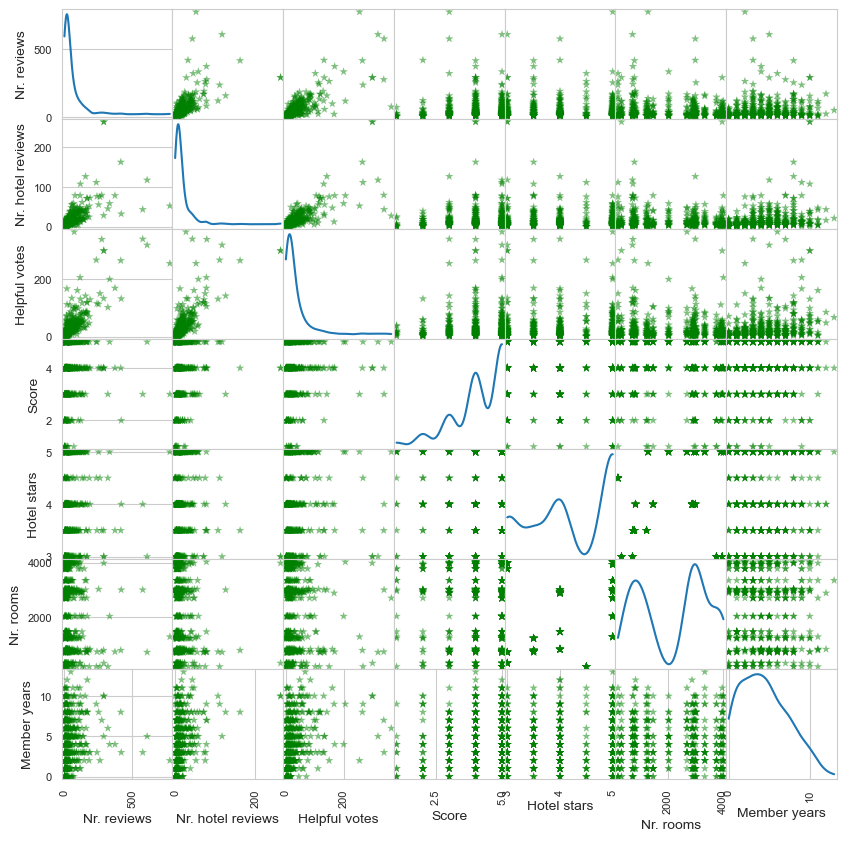

In [25]:
pd.plotting.scatter_matrix(df,
                           figsize=(10,10), 
                           diagonal='kde', 
                           s=40,                            
                           alpha=0.5,
                           marker='*',
                           color='green');

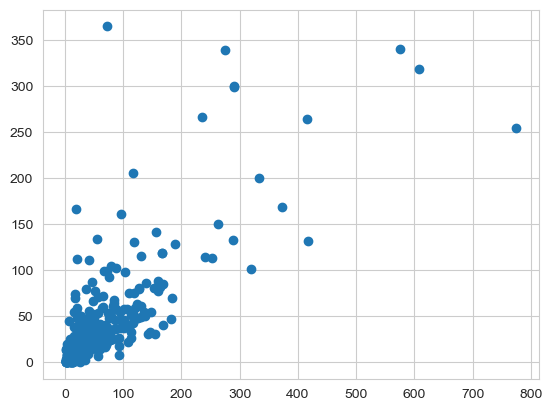

In [26]:
plt.scatter(x=df['Nr. reviews'], y=df['Helpful votes']);

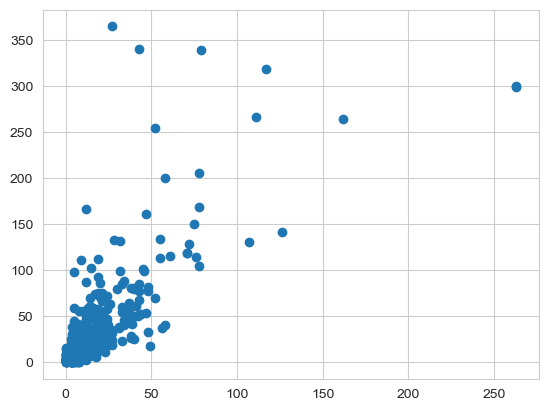

In [27]:
plt.scatter(x=df['Nr. hotel reviews'], y=df['Helpful votes']);

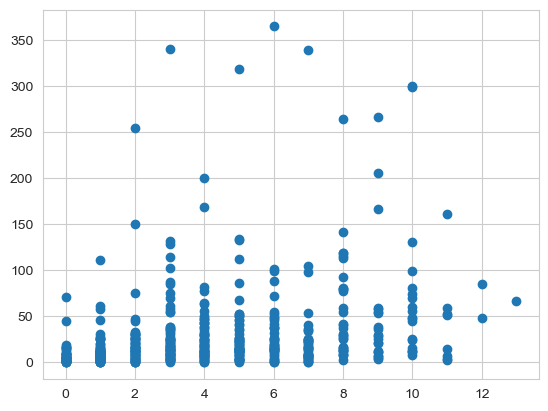

In [28]:
plt.scatter(x=df['Member years'],y=df['Helpful votes']);

Ta thấy được những người là thành viên lâu năm thường sẽ có những nhận xét được cộng đồng upvote nhiều hơn.

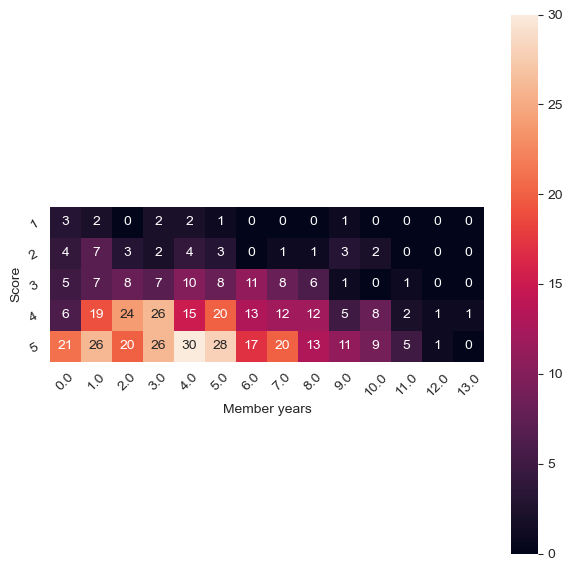

In [29]:
memberyears_score = df.groupby(['Member years','Score']).count().iloc[:,0].unstack().fillna(0).astype(int).T
plt.figure(figsize=(7,7))           
ax = sns.heatmap(memberyears_score, square=True, annot=True, linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

Các thành viên lâu năm thường có những đánh giá ít khắt khe hơn so với những thành viên mới.

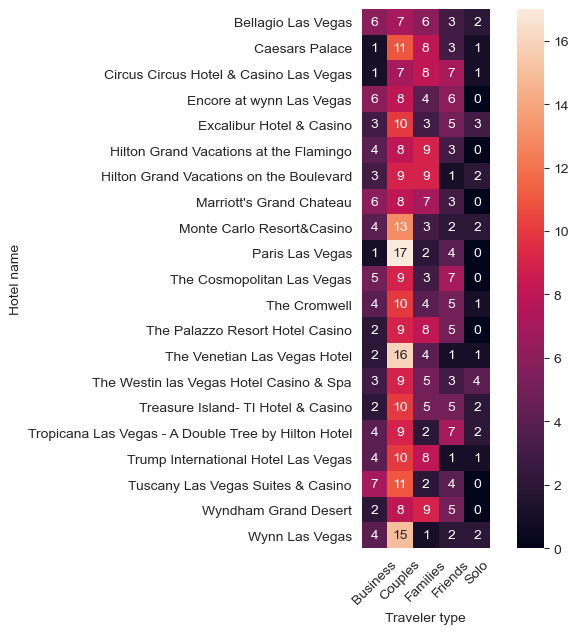

In [30]:
memberyears_score = df.groupby(['Hotel name','Traveler type']).count().iloc[:,0].unstack().fillna(0).astype(int)
plt.figure(figsize=(7,7))           
ax = sns.heatmap(memberyears_score, square=True, annot=True, linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels())
plt.show()

Trong biểu đồ trên, ta thấy được:
- Các khách sạn mà Couple thường chọn nhiều: Paris Las Vegas, The Venetian Las Vegas Hotel, Wynn Las Vegas, Monte Carlo Resort&Casino. Những khách sạn này còn có đặc điểm là ít được những nhóm khách hàng khác lựa chọn.
- Các khách sạn mà Business chọn nhiều: Bellagio Las Vegas, Tuscany Las Vegas Suites & Casino, ....

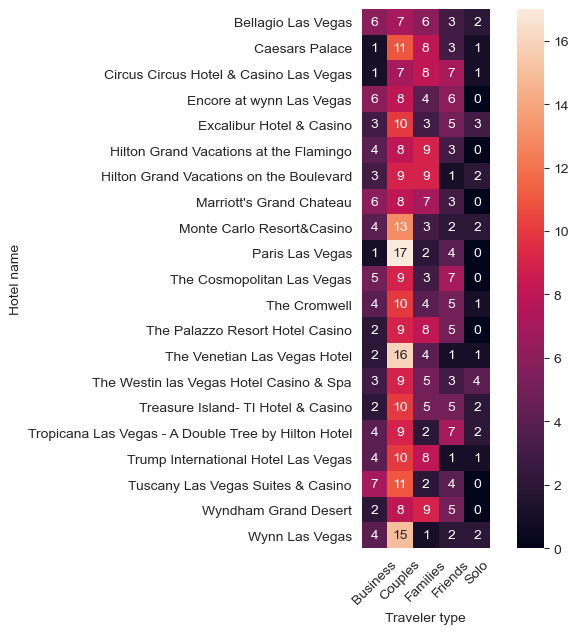

In [31]:
temp_df = df[df['Score']>=4]
memberyears_score2 = df.groupby(['Hotel name','Traveler type']).count().iloc[:,0].unstack().fillna(0).astype(int)
plt.figure(figsize=(7,7))           
ax = sns.heatmap(memberyears_score2, square=True, annot=True, linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels())
plt.show()

Biểu đồ trên là biểu đồ lựa chọn khách sạn theo loại khách, với mức Score>=4. Tương tự, ta có thể lựa chọn được những loại khách sạn phù hợp với từng nhóm khách hàng:
- ...

In [32]:
df.groupby('Hotel name').mean().sort_values(by='Hotel stars',ascending=False)

,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Hotel stars,Nr. rooms,Member years
Hotel name,,,,,,,
Bellagio Las Vegas,27.708333,10.208333,24.875000,4.208333,5.0,3933.0,3.416667
Caesars Palace,38.000000,15.291667,26.375000,4.125000,5.0,3348.0,4.750000
Trump International Hotel Las Vegas,65.000000,13.666667,27.791667,4.375000,5.0,1282.0,4.333333
The Venetian Las Vegas Hotel,32.041667,12.958333,24.000000,4.583333,5.0,4027.0,4.375000
The Palazzo Resort Hotel Casino,44.916667,15.333333,31.375000,4.375000,5.0,3025.0,5.291667
The Cosmopolitan Las Vegas,33.791667,10.125000,28.541667,4.250000,5.0,2959.0,4.500000
Encore at wynn Las Vegas,57.166667,16.333333,36.750000,4.541667,5.0,2034.0,4.750000
Wynn Las Vegas,35.458333,13.833333,38.291667,4.625000,5.0,2700.0,5.416667
The Cromwell,71.541667,20.958333,45.166667,4.083333,4.5,188.0,3.583333


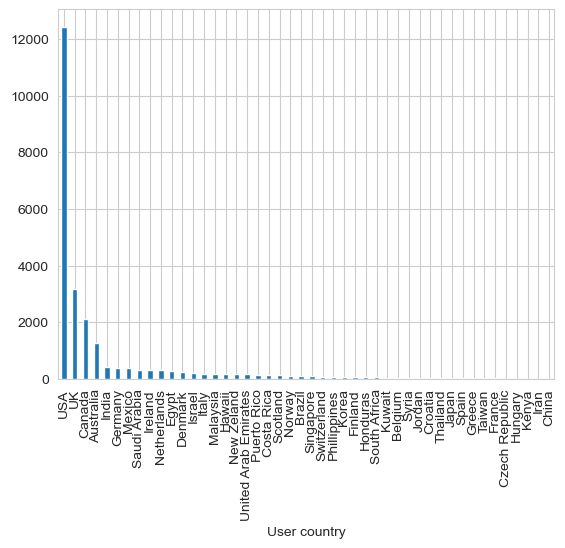

In [33]:
df.groupby('User country').sum()['Nr. reviews'].sort_values(ascending=False).plot(kind='bar');

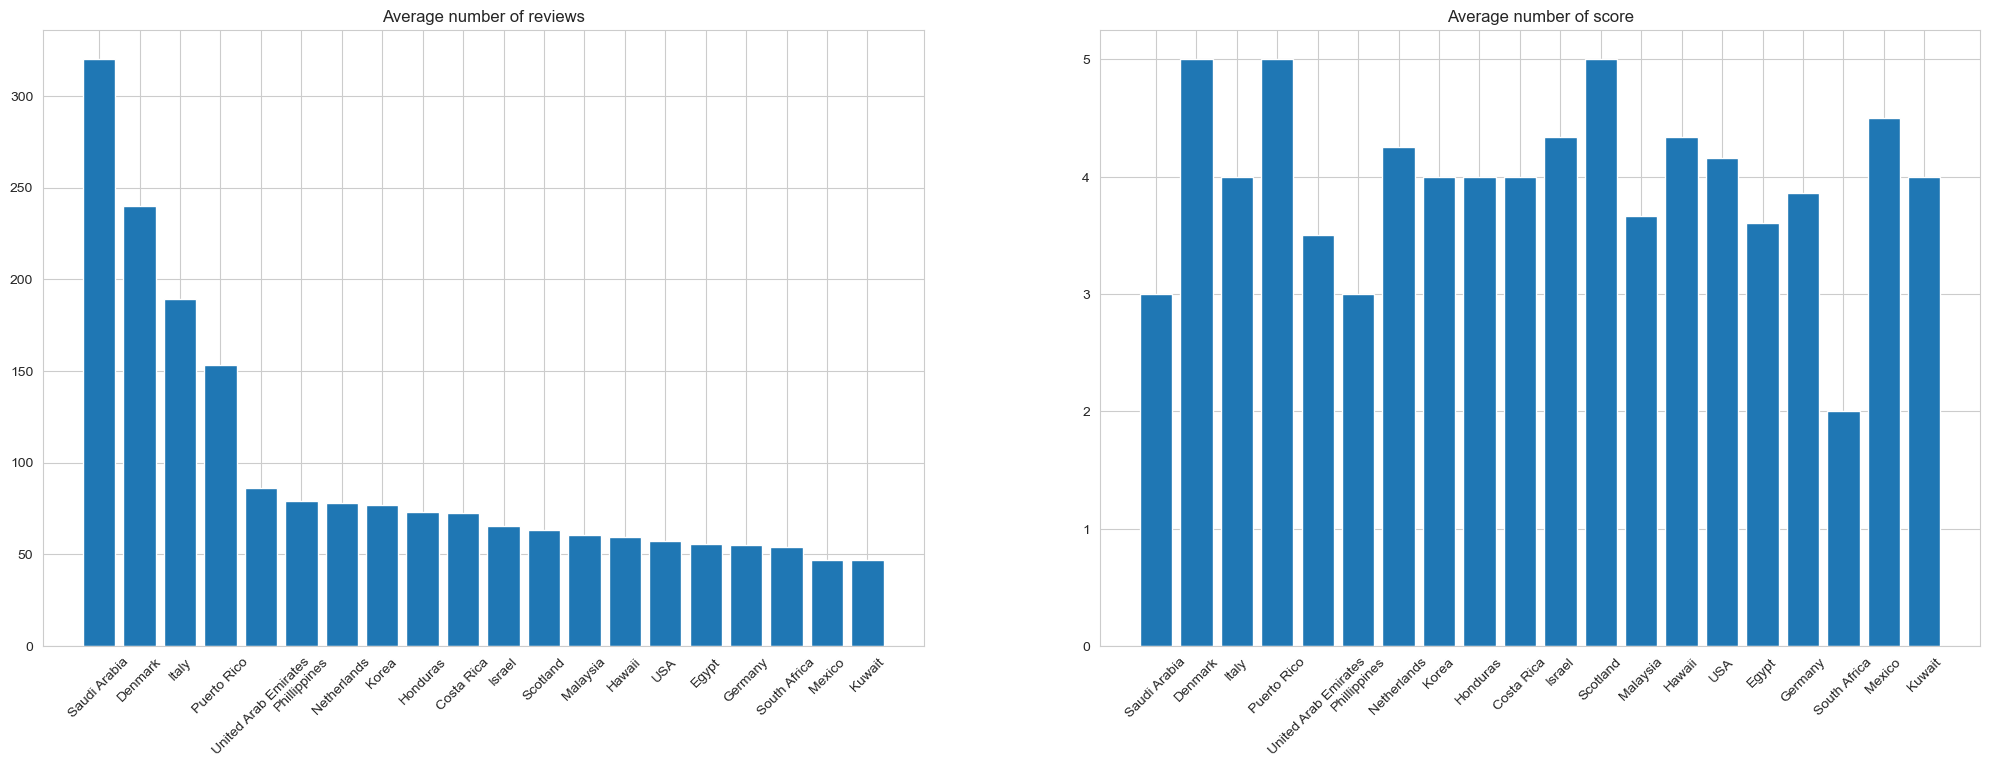

In [34]:
fig, axs = plt.subplots(1,2, figsize=(25,8))
temp_df =df.groupby('User country').mean().sort_values('Nr. reviews', ascending=False)
axs[0].bar(temp_df.iloc[:20,0].index, temp_df.iloc[:20,0].values)
axs[0].set_xticklabels(temp_df.iloc[:20,0].index, rotation=45)
axs[0].set_title('Average number of reviews')
axs[1].bar(temp_df.iloc[:20,3].index, temp_df.iloc[:20,3].values)
axs[1].set_xticklabels(temp_df.iloc[:20,3].index, rotation=45)
axs[1].set_title('Average number of score');

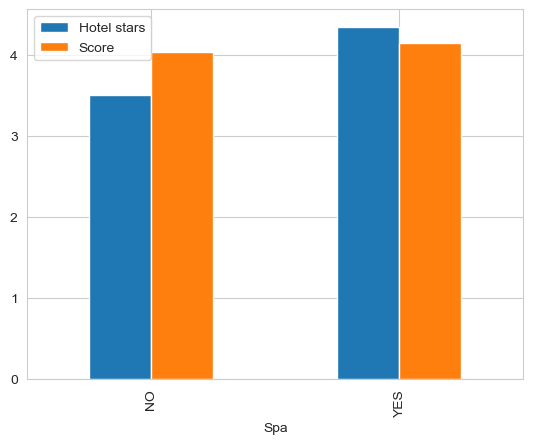

In [35]:
df.groupby('Spa').mean()[['Hotel stars','Score']].plot(kind='bar');

Yếu tố spa gần như không ảnh hưởng đến đánh giá người dùng.

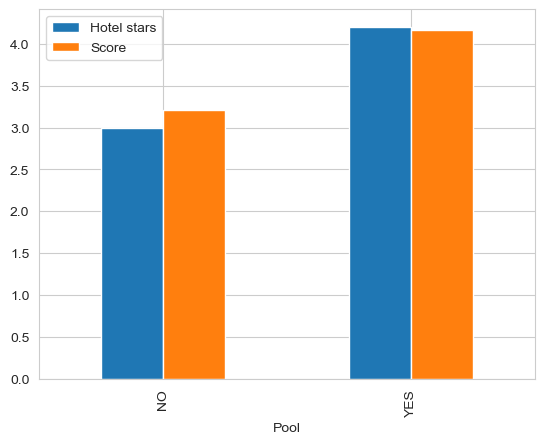

In [36]:
df.groupby('Pool').mean()[['Hotel stars','Score']].plot(kind='bar');

Các khách sạn sẽ được đánh giá cao hơn nếu có hồ bơi.

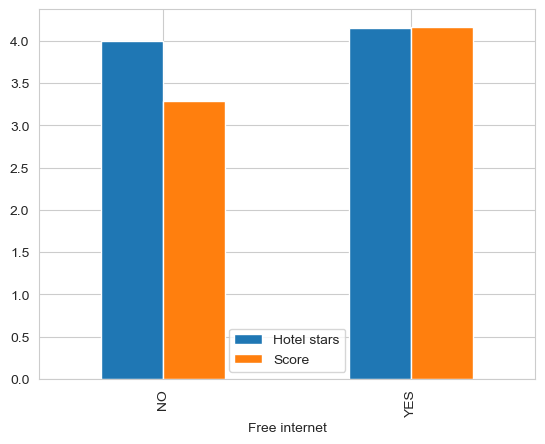

In [37]:
df.groupby('Free internet').mean()[['Hotel stars','Score']].plot(kind='bar');

Ở đây có thể thấy việc có Internet miễn phí sẽ ảnh hưởng lớn đến điểm đánh giá của người dùng.

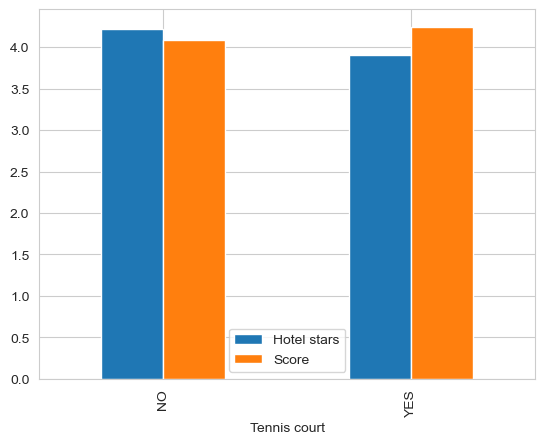

In [38]:
df.groupby('Tennis court').mean()[['Hotel stars','Score']].plot(kind='bar');

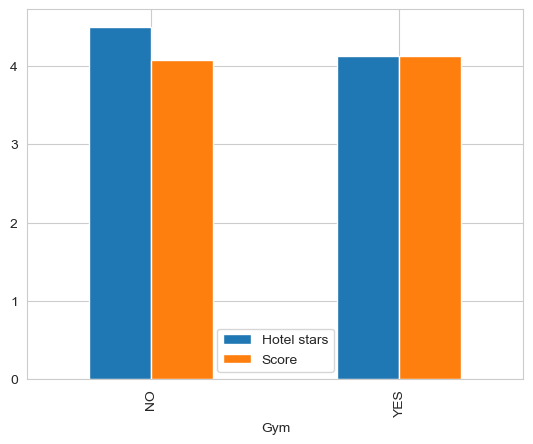

In [39]:
df.groupby('Gym').mean()[['Hotel stars','Score']].plot(kind='bar');

Việc có phòng GYM hay không gần như không ảnh hưởng đến điểm đánh giá của người dùng.

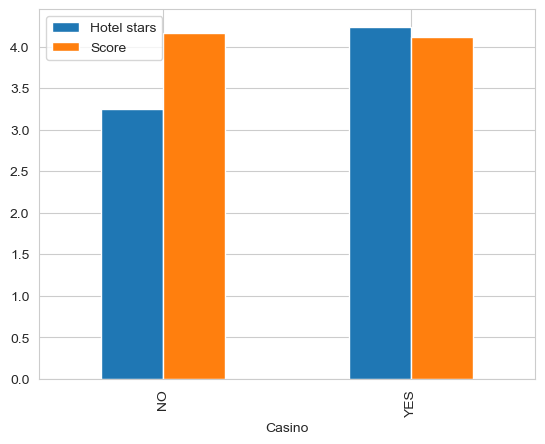

In [40]:
df.groupby('Casino').mean()[['Hotel stars','Score']].plot(kind='bar');

Ở những khách sạn không có Casino, khách hàng đánh giá cao hơn so với số sao của khách sạn, và cũng cao hơn so với những khách sạn có casino.

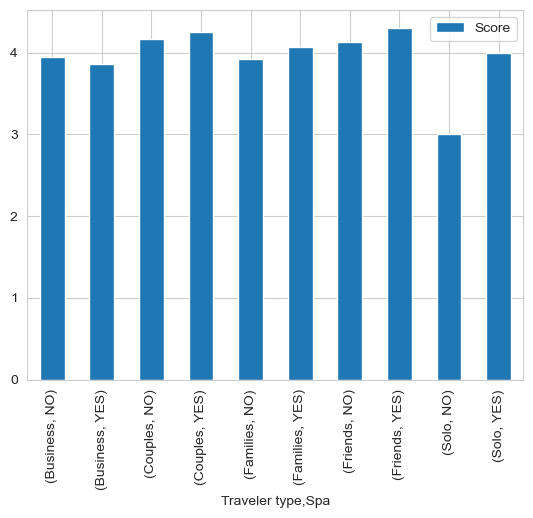

In [41]:
df.groupby(['Traveler type','Spa']).mean()[['Score']].plot(kind='bar');

Ta thấy những người đi Solo sẽ đánh giá cao khách sạn có Spa hơn.

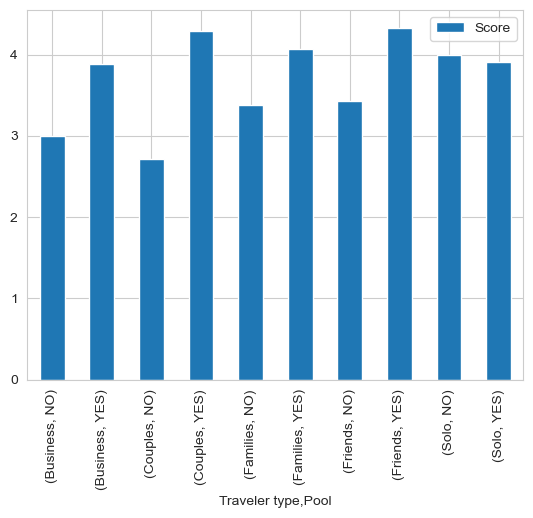

In [42]:
df.groupby(['Traveler type','Pool']).mean()[['Score']].plot(kind='bar');

Trừ những người đi Solo, tất cả các nhóm khách hàng còn lại đều đánh giá khách sạn có hồ bơi cao hơn nhiều so với những nơi không có.

In [43]:
df.groupby(['Traveler type','Casino']).mean()[['Hotel stars','Score']]

Hotel stars     Score
Traveler type Casino                       
Business      NO         3.166667  4.000000
              YES        4.242647  3.867647
Couples       NO         3.250000  4.375000
              YES        4.270202  4.222222
Families      NO         3.250000  3.888889
              YES        4.250000  4.043478
Friends       NO         3.312500  4.500000
              YES        4.168919  4.229730
Solo          YES        4.104167  3.916667

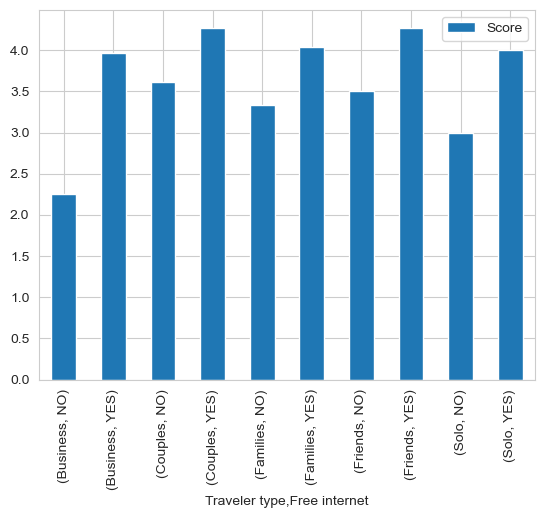

In [44]:
df.groupby(['Traveler type','Free internet']).mean()[['Score']].plot(kind='bar');

Free internet, như đã phân tích bên trên, là yếu tố ảnh hưởng rất nhiều đến mức độ hài lòng của khách hàng.

In [45]:
df.groupby(['Traveler type','Tennis court']).mean()[['Hotel stars','Score']]

Hotel stars     Score
Traveler type Tennis court                       
Business      NO               4.281818  3.909091
              YES              3.789474  3.789474
Couples       NO               4.257764  4.180124
              YES              4.000000  4.396226
Families      NO               4.164835  4.010989
              YES              3.710526  4.052632
Friends       NO               4.194915  4.186441
              YES              3.804348  4.434783
Solo          NO               4.027778  3.833333
              YES              4.333333  4.166667

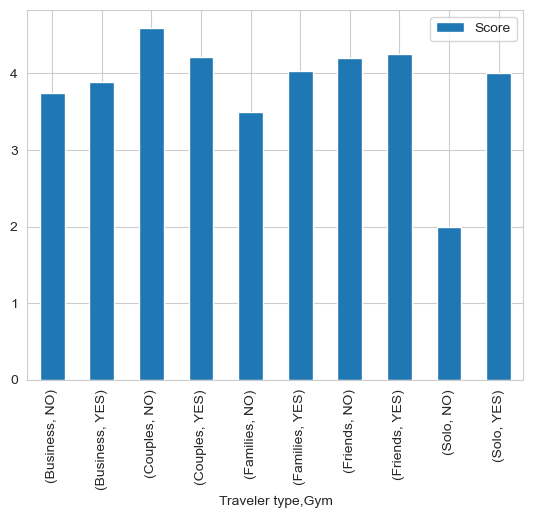

In [46]:
df.groupby(['Traveler type','Gym']).mean()[['Score']].plot(kind='bar');

Ta thấy ở đây, nhóm Families và Solo thường thích khách sạn có phòng GYM hơn.

#### Data Transform

In [47]:
df= pd.get_dummies(df, columns= cat_cols, drop_first= True)

In [48]:
print(df.shape)
df.head()

(504, 110)


,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Nr. rooms,Member years,User country_Belgium,User country_Brazil,User country_Canada,User country_China,...,Review month_May,Review month_November,Review month_October,Review month_September,Review weekday_Monday,Review weekday_Saturday,Review weekday_Sunday,Review weekday_Thursday,Review weekday_Tuesday,Review weekday_Wednesday
0,11,4,13,5,3773,9.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,119,21,75,3,3773,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,36,9,25,5,3773,2.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,14,7,14,4,3773,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,5,2,4,3773,7.0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


##### Data transform to visualization

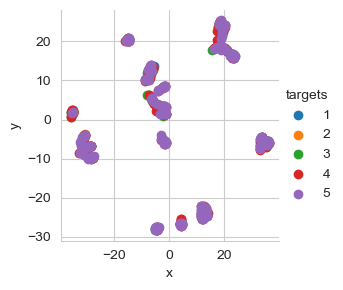

In [49]:
tsne = manifold.TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(df.copy().drop('Score', axis= 1))

tsne_df = pd.DataFrame(
        np.column_stack((transformed_data, df['Score'])), 
        columns=["x", "y", "targets"])
tsne_df.loc[:, "targets"] = tsne_df.targets.astype(int)
grid = sns.FacetGrid(tsne_df, hue="targets")
grid.map(plt.scatter, "x", "y").add_legend()

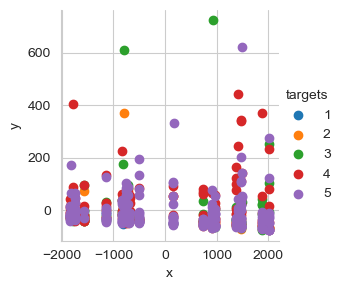

In [50]:
pca = PCA(n_components=2, random_state=42)
transformed_data = pca.fit_transform(df.copy().drop('Score', axis= 1))

pca_df = pd.DataFrame(
        np.column_stack((transformed_data, df['Score'])), 
        columns=["x", "y", "targets"])
pca_df.loc[:, "targets"] = pca_df.targets.astype(int)
grid = sns.FacetGrid(pca_df, hue="targets")
grid.map(plt.scatter, "x", "y").add_legend();

##### Normalization

In [51]:
# vì dữ liệu liên tục có phân phối positive skew nên sẽ dùng log để chuẩn hóa
print(num_cols)

['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Hotel stars', 'Nr. rooms', 'Member years']


In [52]:
log_data = df.copy()
log_data[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Member years']] = np.log1p(log_data[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Member years']])

In [53]:
df['Member years'].value_counts()

3.0     63
1.0     61
4.0     61
5.0     60
2.0     55
7.0     41
6.0     41
0.0     39
8.0     32
9.0     21
10.0    19
11.0     8
12.0     2
13.0     1
Name: Member years, dtype: int64

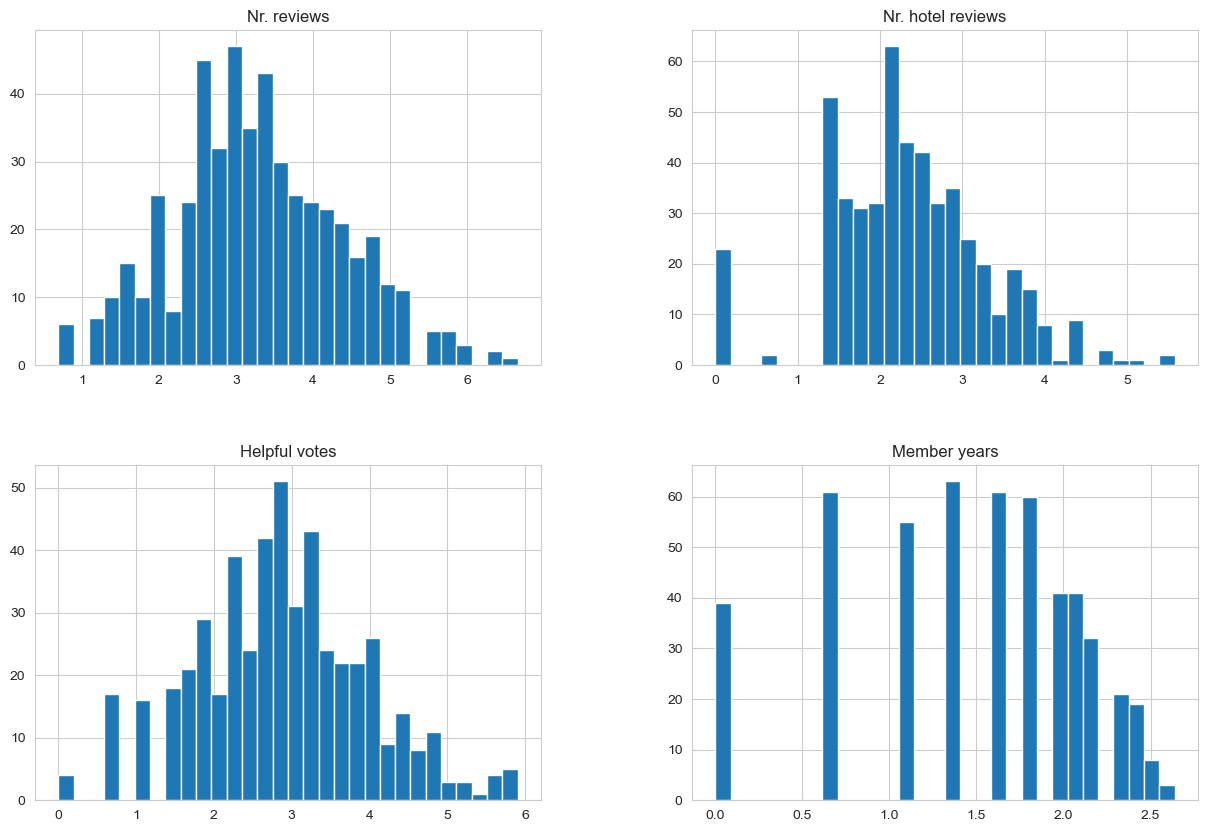

In [54]:
log_data[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Member years']].hist(bins= 30, figsize=(15, 10));

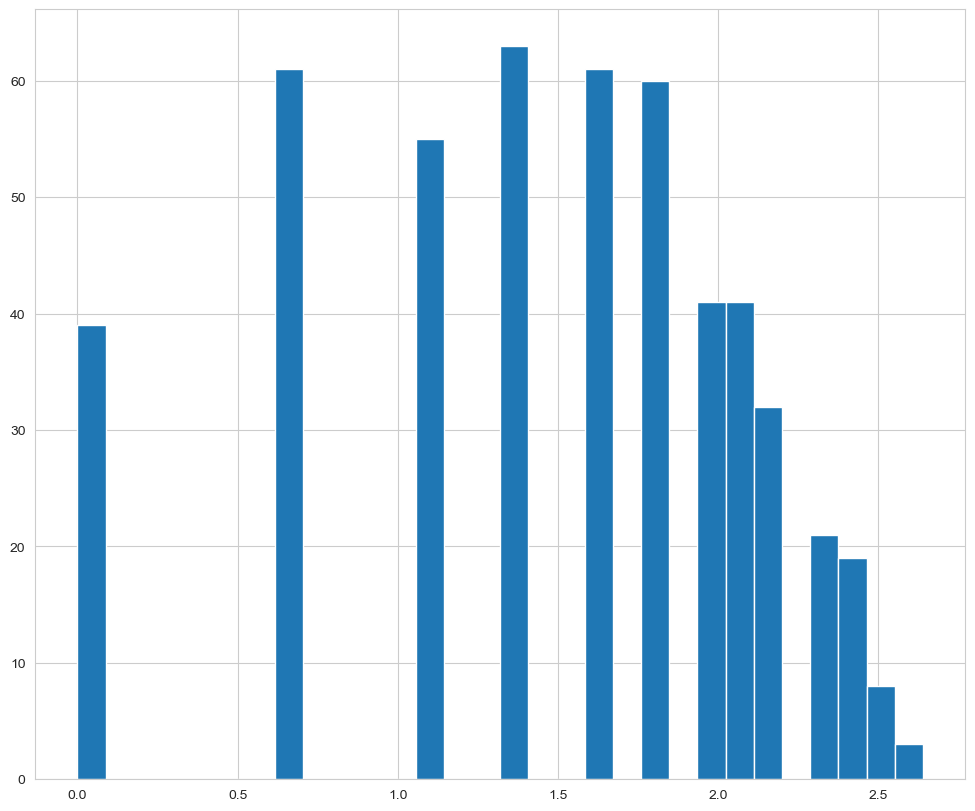

In [55]:
log_data['Member years'].hist(bins= 30, figsize=(12, 10));

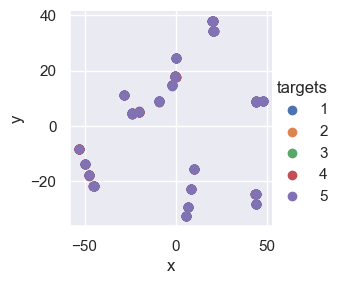

In [56]:
# giảm chiều 
tsne = manifold.TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(log_data.copy().drop('Score', axis= 1))

tsne_log_data = pd.DataFrame(
        np.column_stack((transformed_data, log_data['Score'])), 
        columns=["x", "y", "targets"])
tsne_log_data.loc[:, "targets"] = tsne_log_data.targets.astype(int)
sns.set(rc={'figure.figsize':(15, 9)})
grid = sns.FacetGrid(tsne_log_data, hue="targets")
grid.map(plt.scatter, "x", "y").add_legend();

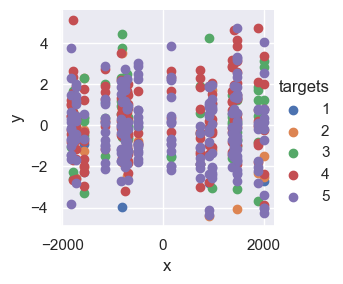

In [57]:
pca = PCA(n_components=2, random_state=42)
transformed_data = pca.fit_transform(log_data.copy().drop('Score', axis= 1))

pca_log_data = pd.DataFrame(
        np.column_stack((transformed_data, log_data['Score'])), 
        columns=["x", "y", "targets"])
pca_log_data.loc[:, "targets"] = pca_log_data.targets.astype(int)
grid = sns.FacetGrid(pca_log_data, hue="targets")
grid.map(plt.scatter, "x", "y").add_legend();

In [58]:
log_data.to_csv('../data/new_data.csv', index= False)